# General info on the fullCyc dataset (as it pertains to SIPSim validation)

* Simulating 12C gradients
* Determining if simulated taxon abundance distributions resemble the true distributions
* Simulation parameters to infer from dataset:
  * Infer total richness of bulk soil community 
    * richness of starting community
  * Infer abundance distribution of bulk soil community
    * NO: distribution fit
    * INSTEAD: using relative abundances of bulk soil community
  * Get distribution of total OTU abundances per fraction
    * Number of sequences per sample

# User variables

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/'
physeqDir = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/phyloseq/'
physeqBulkCore = 'bulk-core'
physeqSIP = 'SIP-core_unk'

# Init

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(phyloseq)
library(fitdistrplus)
library(sads)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘MASS’


  res = super(Function, self).__call__(*new_arg

In [4]:
%%R

dir.create(workDir, showWarnings=FALSE)

# Loading phyloseq datasets

In [5]:
%%R
# bulk core samples
F = file.path(physeqDir, physeqBulkCore)
physeq.bulk = readRDS(F)
physeq.bulk.m = physeq.bulk %>% sample_data
physeq.bulk


Error in gzfile(file, "rb") : cannot open the connection


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in gzfile(file, "rb") : cannot open the connection

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt

In [6]:
%%R
# SIP core samples
F = file.path(physeqDir, physeqSIP)
physeq.SIP = readRDS(F)
physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP


Error in gzfile(file, "rb") : cannot open the connection


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  cannot open compressed file '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/phyloseq//SIP-core_unk', probable reason 'No such file or directory'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Selecting gradients to simulate

In [303]:
%%R
physeq.bulk.12C = prune_samples(physeq.bulk.m$Substrate == '12C-Con', physeq.bulk) %>%
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.bulk.12C.m = physeq.bulk.12C %>% sample_data
physeq.bulk.12C

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4370 taxa and 6 samples ]
sample_data() Sample Data:       [ 6 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 4370 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4370 tips and 4369 internal nodes ]


In [304]:
%%R
physeq.SIP.12C = prune_samples(physeq.SIP.m$Substrate == '12C-Con', physeq.SIP) %>%
    transform_sample_counts(function(x) x/sum(x))
physeq.SIP.12C

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12358 taxa and 142 samples ]
sample_data() Sample Data:       [ 142 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 12358 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 12358 tips and 12357 internal nodes ]


In [305]:
%%R
# number of fractions per 12C day
as.Num = function(x) as.numeric(as.character(x))

physeq.SIP.12C %>% sample_data %>% 
    as.matrix %>% as.data.frame %>% 
    group_by(Day) %>%
    summarize(n = n()) %>%
    mutate(Day = as.Num(Day)) %>%
    arrange(Day)

Source: local data frame [6 x 2]

    Day     n
  (dbl) (int)
1     1    25
2     3    23
3     6    23
4    14    23
5    30    24
6    48    24


# Infer total richness of bulk soil community 

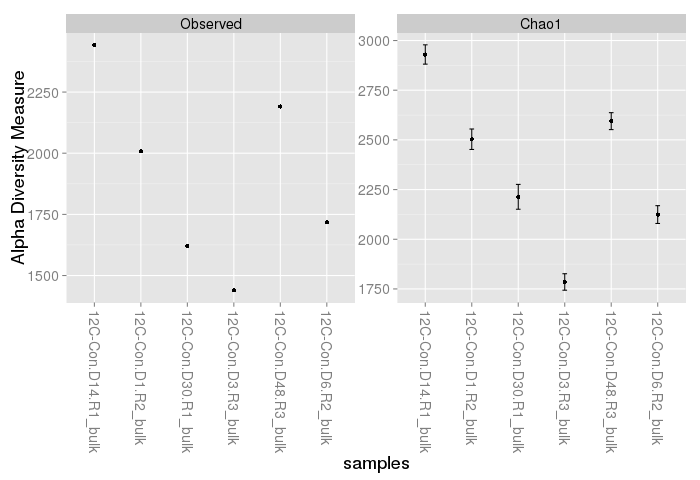

In [323]:
%%R -w 700

p = plot_richness(physeq.bulk.12C, measures=c('Observed', 'Chao1'))
p = p + theme(text = element_text(size=18))
p

In [339]:
%%R
ggplot_build(p)$data[[2]] %>% arrange(PANEL, x)

   x        y     ymin     ymax PANEL group xmin xmax
1  1 2443.000       NA       NA     1     1 0.95 1.05
2  2 2008.000       NA       NA     1     3 1.95 2.05
3  3 1621.000       NA       NA     1     5 2.95 3.05
4  4 1440.000       NA       NA     1     7 3.95 4.05
5  5 2191.000       NA       NA     1     9 4.95 5.05
6  6 1718.000       NA       NA     1    11 5.95 6.05
7  1 2929.862 2881.305 2978.418     2     2 0.95 1.05
8  2 2503.459 2451.968 2554.950     2     4 1.95 2.05
9  3 2213.610 2151.041 2276.178     2     6 2.95 3.05
10 4 1784.926 1743.502 1826.351     2     8 3.95 4.05
11 5 2594.394 2551.777 2637.010     2    10 4.95 5.05
12 6 2124.291 2079.485 2169.098     2    12 5.95 6.05


#  Infer abundance distribution of bulk soil community

* distribution fit

In [280]:
%%R
df.OTU = physeq.bulk.12C %>%
    transform_sample_counts(function(x) x/sum(x)) %>%
    otu_table %>%
    as.matrix %>% as.data.frame 

df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>% 
    gather('sample', 'abundance', 1:(ncol(df.OTU)-1))

df.OTU %>% head(n=3)

       OTU             sample    abundance
1 OTU.1101 12C-Con.D3.R3_bulk 0.000000e+00
2 OTU.1130 12C-Con.D3.R3_bulk 9.601536e-05
3 OTU.9833 12C-Con.D3.R3_bulk 9.601536e-05


[1] "1"
[1] "3"
[1] "6"
[1] "14"
[1] "30"
[1] "48"


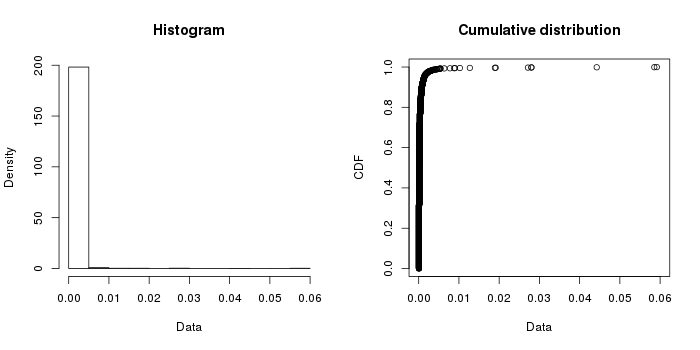

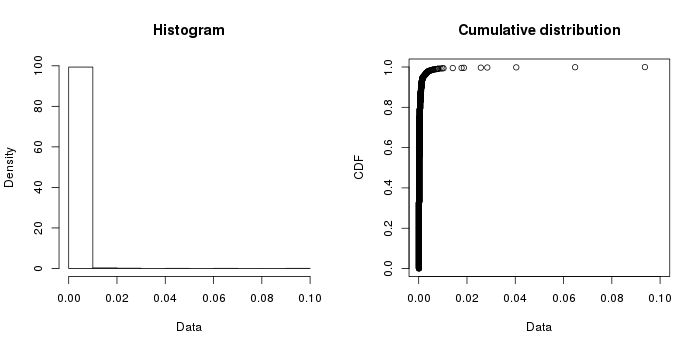

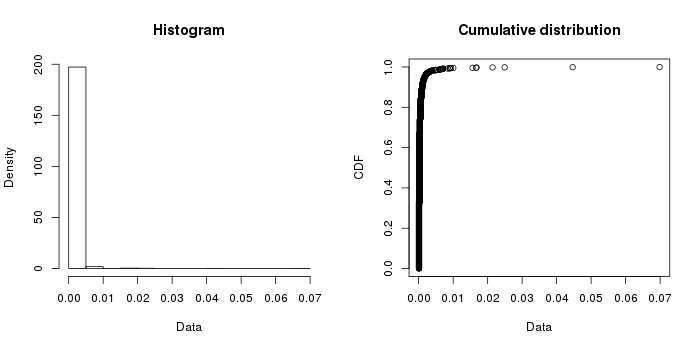

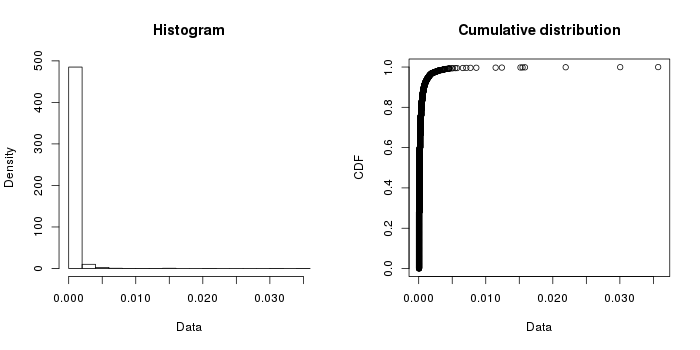

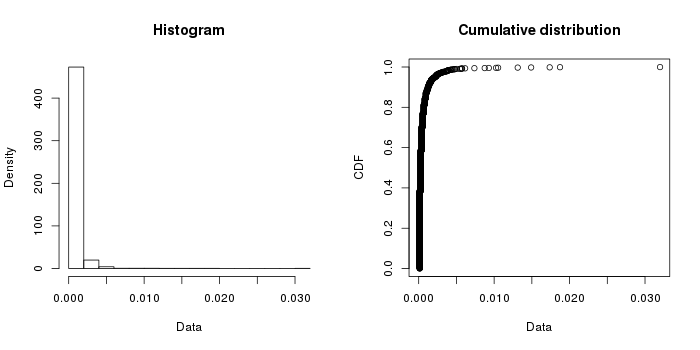

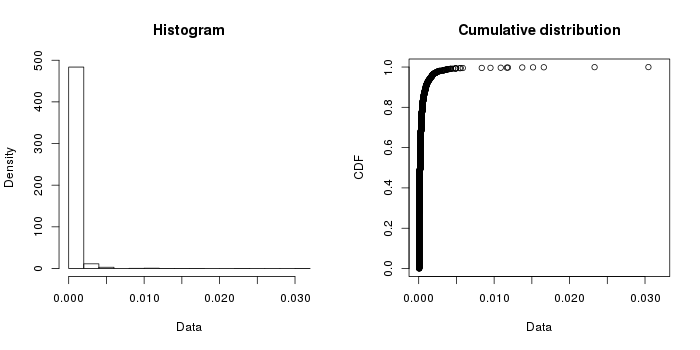

In [281]:
%%R -w 700 -h 350


days = physeq.bulk.12C.m$Day %>% unique %>% as.character
days = reorder(days, days %>% as.Num)

df.OTU.l = list()
for(day in days %>% sort){
    day %>% print
    rx = paste(c('\\.D', day, '\\.'), collapse='')
    df.OTU.l[[day]] = df.OTU %>% 
                filter(grepl(rx, sample), abundance > 0)
    plotdist(df.OTU.l[[day]]$abundance)
}


$`1`
summary statistics
------
min:  6.171316e-05   max:  0.05918292 
median:  0.0001234263 
mean:  0.000498008 
estimated sd:  0.002527486 
estimated skewness:  17.3276 
estimated kurtosis:  353.0851 

$`3`
summary statistics
------
min:  9.601536e-05   max:  0.09371099 
median:  0.0001920307 
mean:  0.0006944444 
estimated sd:  0.003522151 
estimated skewness:  18.90537 
estimated kurtosis:  433.01 

$`6`
summary statistics
------
min:  8.966197e-05   max:  0.06984668 
median:  0.0001793239 
mean:  0.0005820722 
estimated sd:  0.002405602 
estimated skewness:  19.2723 
estimated kurtosis:  481.0681 

$`14`
summary statistics
------
min:  5.145621e-05   max:  0.03571061 
median:  0.0001543686 
mean:  0.0004093328 
estimated sd:  0.001370901 
estimated skewness:  15.40056 
estimated kurtosis:  319.4511 

$`30`
summary statistics
------
min:  0.0001367241   max:  0.03199344 
median:  0.0002734482 
mean:  0.0006169031 
estimated sd:  0.001407484 
estimated skewness:  11.48746 
estimated 

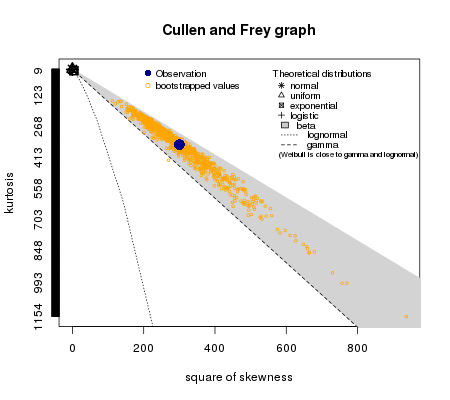

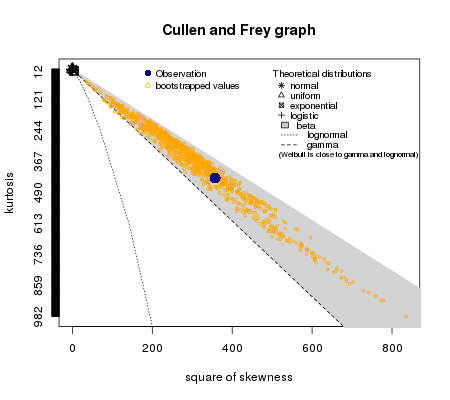

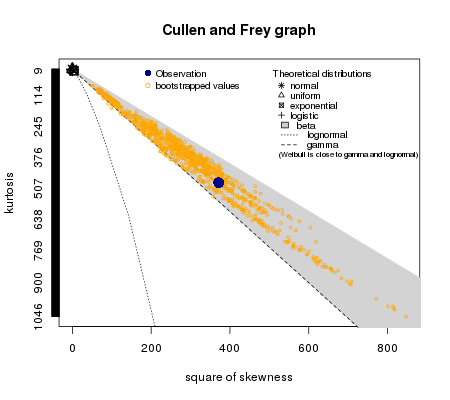

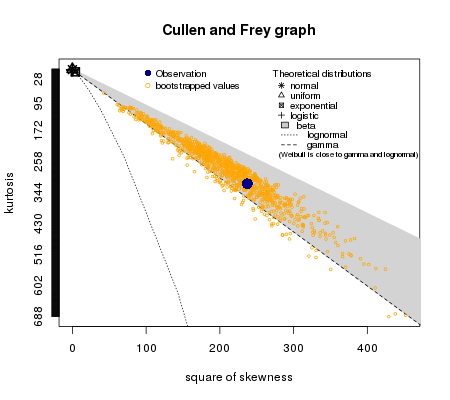

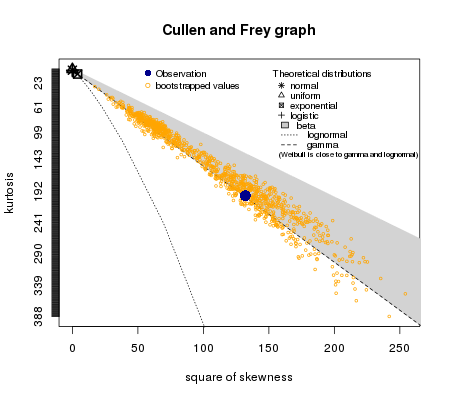

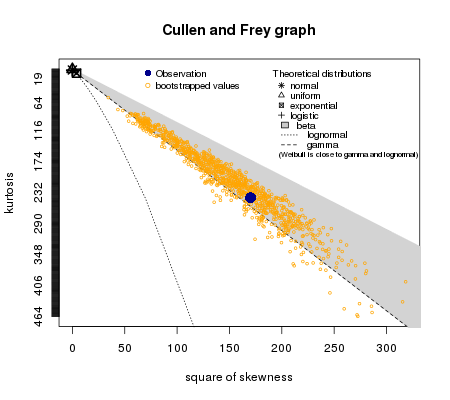

In [282]:
%%R -w 450 -h 400

lapply(df.OTU.l, function(x) descdist(x$abundance, boot=1000))

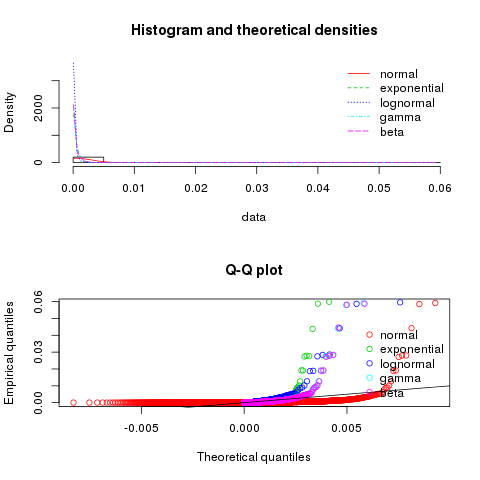

In [294]:
%%R
tmp1 = df.OTU.l[['1']]$abundance

f.norm = fitdist(tmp1, 'norm')
f.exp = fitdist(tmp1, 'exp')
f.logn = fitdist(tmp1, 'lnorm')
f.gamma = fitdist(tmp1, 'gamma')
f.beta = fitdist(tmp1, 'beta')

f.list = list(f.norm, f.exp, f.logn, f.gamma, f.beta)

plot.legend = c('normal', 'exponential', 'lognormal', 'gamma', 'beta')

par(mfrow = c(2,1))
denscomp(f.list, legendtext=plot.legend)
qqcomp(f.list, legendtext=plot.legend)

In [295]:
%%R
gofstat(f.list, fitnames=plot.legend)

Goodness-of-fit statistics
                                  normal exponential  lognormal     gamma
Kolmogorov-Smirnov statistic   0.4314581    0.333942  0.1583872  0.237266
Cramer-von Mises statistic   118.9343834   74.597984 10.7887734 37.706637
Anderson-Darling statistic           Inf         Inf 70.9860349       Inf
                                   beta
Kolmogorov-Smirnov statistic  0.2378843
Cramer-von Mises statistic   37.9793220
Anderson-Darling statistic          Inf

Goodness-of-fit criteria
                                  normal exponential lognormal     gamma
Aikake's Information Criterion -18316.35   -26523.26 -28624.47 -26925.83
Bayesian Information Criterion -18305.14   -26517.65 -28613.26 -26914.62
                                    beta
Aikake's Information Criterion -26910.79
Bayesian Information Criterion -26899.58


In [296]:
%%R
summary(f.beta)

Fitting of the distribution ' beta ' by maximum likelihood 
Parameters : 
           estimate  Std. Error
shape1    0.6052314  0.01604951
shape2 1206.9991938 47.11957568
Loglikelihood:  13457.39   AIC:  -26910.79   BIC:  -26899.58 
Correlation matrix:
          shape1    shape2
shape1 1.0000000 0.6786354
shape2 0.6786354 1.0000000



In [299]:
%%R
tmp1 %>% summary %>% print
rbeta(10000, 0.605, 1206.999) %>% summary

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
6.171e-05 6.171e-05 1.234e-04 4.980e-04 3.086e-04 5.918e-02 
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 7.532e-05 2.663e-04 4.969e-04 6.692e-04 6.318e-03 


#### Notes

* Instead of trying to simulate OTU abundances based on a distribution, I will use the observed abundances of each OTU

# Get distribution of total OTU abundances per fraction

* This provides the parameters for simulating OTU table subsampling (ie., sequencing simulation)

In [307]:
%%R
physeq.SIP.12C = prune_samples(physeq.SIP.m$Substrate == '12C-Con', physeq.SIP)
physeq.SIP.12C

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12358 taxa and 142 samples ]
sample_data() Sample Data:       [ 142 samples by 17 sample variables ]
tax_table()   Taxonomy Table:    [ 12358 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 12358 tips and 12357 internal nodes ]


In [308]:
%%R
df.OTU = physeq.SIP.12C %>% 
    otu_table %>%
    as.matrix %>% as.data.frame 

df.OTU$OTU = rownames(df.OTU)
df.OTU = df.OTU %>% 
    gather('sample', 'abundance', 1:(ncol(df.OTU)-1))

df.OTU %>% head(n=3)

       OTU            sample abundance
1 OTU.1101 12C-Con.D1.R2_F23         2
2 OTU.1130 12C-Con.D1.R2_F23         0
3 OTU.9833 12C-Con.D1.R2_F23         0


Number of samples (fractions):  142 


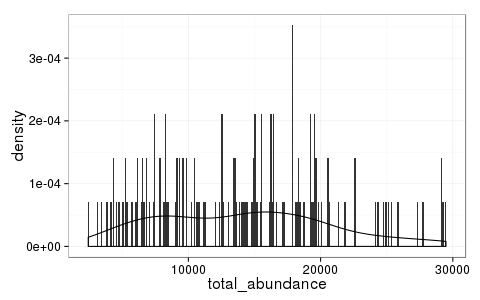

In [309]:
%%R -h 300

df.OTU.s = df.OTU %>%
    group_by(sample) %>%
    summarize(total_abundance = sum(abundance))

cat('Number of samples (fractions): ', nrow(df.OTU.s), '\n')

p = ggplot(df.OTU.s, aes(total_abundance)) +
    geom_histogram(binwidth=100, aes(y = ..density..)) +
    geom_density() + 
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
p

#### Notes

* Total abundances of each sample

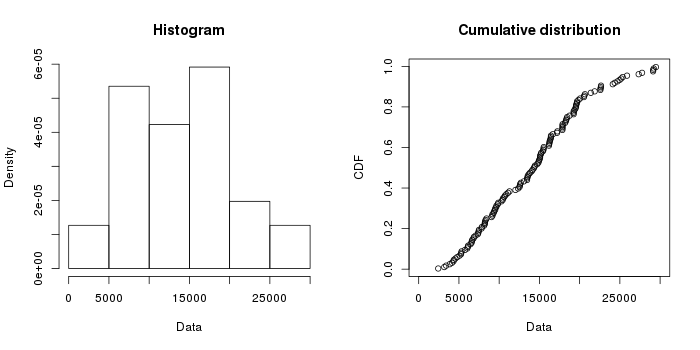

In [310]:
%%R -w 700 -h 350

plotdist(df.OTU.s$total_abundance)

summary statistics
------
min:  2428   max:  29480 
median:  14326.5 
mean:  14138.24 
estimated sd:  6503.14 
estimated skewness:  0.3214032 
estimated kurtosis:  2.445484 


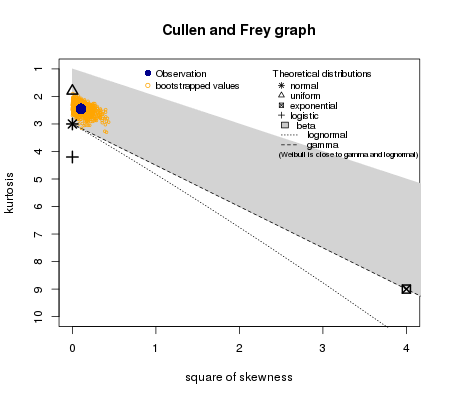

In [311]:
%%R -w 450 -h 400
descdist(df.OTU.s$total_abundance, boot=1000)

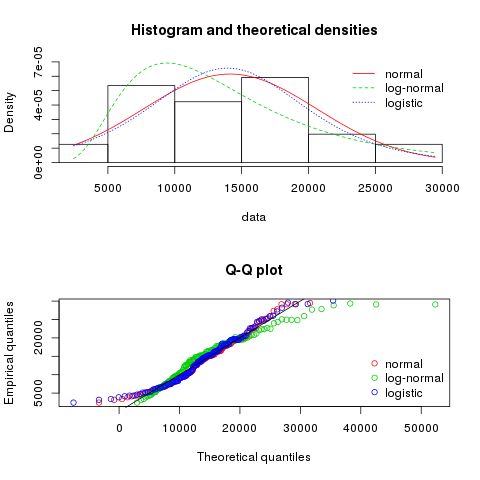

In [312]:
%%R
f.n = fitdist(df.OTU.s$total_abundance, 'norm')
f.ln = fitdist(df.OTU.s$total_abundance, 'lnorm')
f.ll = fitdist(df.OTU.s$total_abundance, 'logis')
f.list = list(f.n, f.ln, f.ll)

plot.legend = c('normal', 'log-normal', 'logistic')

par(mfrow = c(2,1))
denscomp(f.list, legendtext=plot.legend)
qqcomp(f.list, legendtext=plot.legend)

In [313]:
%%R

gofstat(list(f.n, f.ln, f.ll), fitnames=plot.legend)

Goodness-of-fit statistics
                                 normal log-normal   logistic
Kolmogorov-Smirnov statistic 0.07478719  0.1203950 0.07448995
Cramer-von Mises statistic   0.11357745  0.3740005 0.13550439
Anderson-Darling statistic   0.85383850  2.0350254 0.99553341

Goodness-of-fit criteria
                                 normal log-normal logistic
Aikake's Information Criterion 2899.506   2906.347 2906.681
Bayesian Information Criterion 2905.418   2912.259 2912.592


In [314]:
%%R
summary(f.ln)

Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
         estimate Std. Error
meanlog 9.4317868 0.04464078
sdlog   0.5319562 0.03156529
Loglikelihood:  -1451.173   AIC:  2906.347   BIC:  2912.259 
Correlation matrix:
        meanlog sdlog
meanlog       1     0
sdlog         0     1



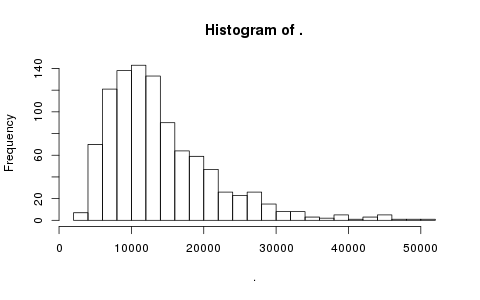

In [315]:
%%R -h 300
rlnorm(1000, 9.432, 0.5) %>% hist(breaks=30)